In [47]:
%pip install scikit-learn
%pip install tqdm
%pip install pandas
%pip install spacy
%pip install matplotlib
%pip install seaborn
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/160.4 kB ? eta -:--:--
     ------- ----------------------------- 30.7/160.4 kB 660.6 kB/s eta 0:00:01
     ---------------- -------------------- 71.7/160.4 kB 787.7 kB/s eta 0:00:01
     --------------------- --------------- 92.2/160.4 kB 655.4 kB/s eta 0:00:01
     -------------------------------- --- 143.4/160.4 kB 778.5 kB/s eta 0:00:01
     ------------------------------------ 160.4/160.4 kB 802.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB 1.9 MB/s eta 0:00:04
    --------------------------------------- 0.1/7.6 MB 1.3 MB/s eta 0:00:06
    --------------------------------------- 0.2/7.6 MB 1.1 MB/s eta 0:00:07
   - --------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.6 kB 991.0 kB/s eta 0:00:01
   ------------ --------------------------- 92.2/294.6 kB 1.1 MB/s eta 0:00:01
   -------------------- ------------------- 153.6/294.6 kB 1.1 MB/s eta 0:00:01
   --------------------------- ------------ 204.8/294.6 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.6 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 975.2 kB/s eta 0:00:14
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:13
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:13
  

In [102]:
from tqdm import tqdm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
import json


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [103]:
def preTraitement():
    data_list = []

    with open('goodreads_reviews_spoiler.json', 'r') as fichier_json:
        lines = fichier_json.readlines()  
        for ligne in tqdm(lines, desc='Chargement des données'):
            try:
                objet_json = json.loads(ligne)
                data_list.append(objet_json)
            except json.JSONDecodeError:
                pass

    dataFrame = pd.json_normalize(data_list)

    dataFrame = dataFrame[dataFrame['has_spoiler'] == True]

    data_json = dataFrame.to_dict(orient='records')

    print(bcolors.OKBLUE + "Ecriture dans onlyspoilers.json..." + bcolors.ENDC)
    with open('onlyspoilers.json', 'w') as fichier_resultat:
        json.dump(data_json, fichier_resultat, indent=4)
    print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

In [104]:
def spoilersFilter():
    print(bcolors.OKBLUE + "Chargement des données..." + bcolors.ENDC)
    dataFrame = pd.read_json('onlyspoilers.json')
    print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

    print(bcolors.OKBLUE + "Filtrage..." + bcolors.ENDC)
    dataFrame = dataFrame.drop_duplicates(subset=['user_id', 'book_id'])
    dataFrame['full_text'] = dataFrame['review_sentences'].apply(lambda sentences: ' '.join([sentence[1] for sentence in sentences]))
    dataFrame['label'] = dataFrame['rating'].apply(lambda x: 1 if x >= 3 else 0)  # 1 pour favorable, 0 pour défavorable
    dataFrame = dataFrame[['rating', 'label', 'full_text']]
    dataFrame = dataFrame.dropna(subset=['rating', 'label', 'full_text'])
    print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

    # Sélectionner 2500 lignes de chaque groupe 'label' (favorable ou défavorable)
    dataFrame_reduis = dataFrame.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 2500)))

    print(bcolors.OKBLUE + "Ecriture dans data.json..." + bcolors.ENDC)
    data_json = dataFrame_reduis.to_dict(orient='records')
    with open('data.json', 'w') as fichier_resultat:
        json.dump(data_json, fichier_resultat, indent=4)
    print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

In [105]:
preTraitement()
spoilersFilter()

Chargement des données:  13%|█▎        | 174998/1378033 [00:01<00:14, 82296.80it/s] 

In [ ]:
import string

print(bcolors.OKBLUE + "Lecture..." + bcolors.ENDC)
dataFrame = pd.read_json('data.json')
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

print(bcolors.OKBLUE + "Prétraitement avec spaCy..." + bcolors.ENDC)
punctuations = string.punctuation
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
print(bcolors.OKCYAN + "nlp traitement..." + bcolors.ENDC)
def preprocess(texts):
    return [' '.join([token.lemma_ for token in doc if not token.is_stop and token.lemma_ not in punctuations]) 
            for doc in tqdm(nlp.pipe(texts, batch_size=50), total=len(texts))]
dataFrame['processed_text'] = preprocess(dataFrame['full_text'].tolist())
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

print(bcolors.OKBLUE + "Vectorisation..." + bcolors.ENDC)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dataFrame['processed_text'])
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

Lecture...
OK
Prétraitement avec spaCy...
nlp traitement...


100%|██████████| 5000/5000 [02:01<00:00, 41.06it/s]


OK
Vectorisation...
OK


Réduction de dimension avec TruncatedSVD...
Réduction de dimension avec t-SNE...
Visualisation...


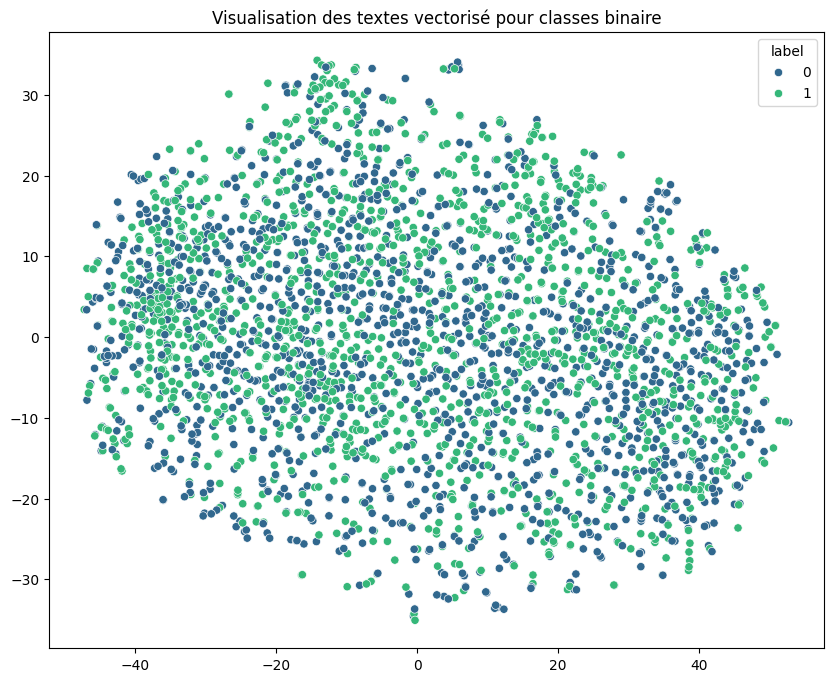

In [ ]:
y = dataFrame['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

sample_size = 3000
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sampled = X_train[indices]
y_sampled = y_train.iloc[indices]

print("Réduction de dimension avec TruncatedSVD...")
svd = TruncatedSVD(n_components=50)
X_reduced_svd = svd.fit_transform(X_sampled)

print("Réduction de dimension avec t-SNE...")
X_reduced_tsne = TSNE(n_components=2).fit_transform(X_reduced_svd)

print("Visualisation...")
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_reduced_tsne[:, 0], y=X_reduced_tsne[:, 1], hue=y_sampled, palette="viridis")
plt.title("Visualisation des textes vectorisé pour classes binaire")
plt.show()

In [ ]:
print(bcolors.OKBLUE + "KNN..." + bcolors.ENDC)
knn_bin_model = KNeighborsClassifier(n_jobs=-1)
knn_bin_params = {'n_neighbors': [3, 5, 7, 9]}
knn_bin_grid = GridSearchCV(knn_bin_model, knn_bin_params)
knn_bin_grid.fit(X_train, y_train)
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

print(bcolors.OKBLUE + "Évaluation de KNN..." + bcolors.ENDC)
prediction = knn_bin_grid.predict(X_test)
print("KNN Classification Report")
print(classification_report(y_test, prediction, zero_division=1))
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

KNN...
OK
Évaluation de KNN...
KNN Classification Report
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       508
           1       0.55      0.60      0.57       492

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000

OK


Réduction de dimension avec TruncatedSVD...
Réduction de dimension avec t-SNE...
Visualisation...


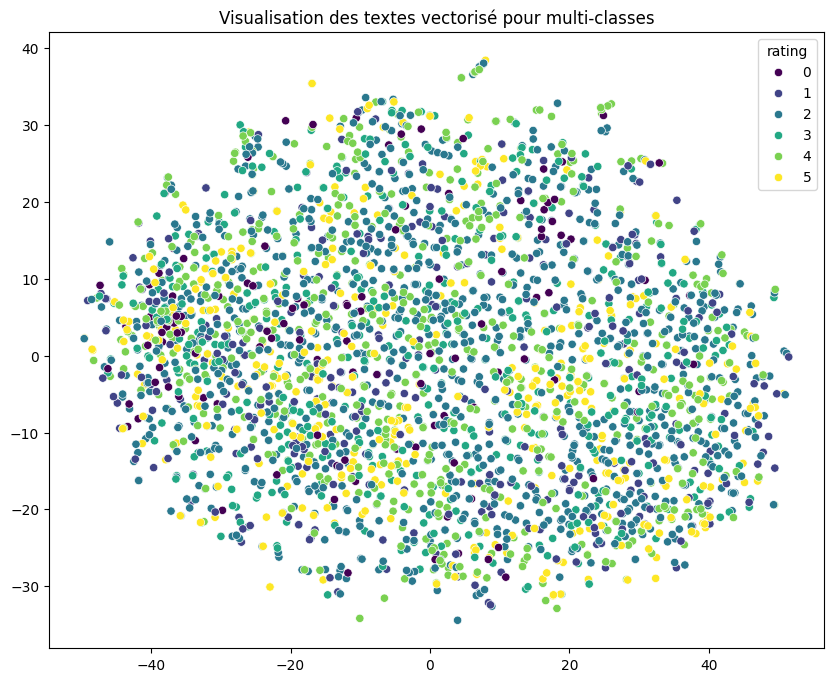

In [ ]:
y = dataFrame['rating']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

sample_size = 3000
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sampled = X_train[indices]
y_sampled = y_train.iloc[indices]

print("Réduction de dimension avec TruncatedSVD...")
svd = TruncatedSVD(n_components=50)
X_reduced_svd = svd.fit_transform(X_sampled)

print("Réduction de dimension avec t-SNE...")
X_reduced_tsne = TSNE(n_components=2).fit_transform(X_reduced_svd)

print("Visualisation...")
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_reduced_tsne[:, 0], y=X_reduced_tsne[:, 1], hue=y_sampled, palette="viridis")
plt.title("Visualisation des textes vectorisé pour multi-classes")
plt.show()

In [ ]:
print(bcolors.OKBLUE + "KNN..." + bcolors.ENDC)
knn_multi_model = KNeighborsClassifier(n_jobs=-1)
knn_multi_params = {'n_neighbors': [1, 3, 5, 7]}
knn_multi_grid = GridSearchCV(knn_multi_model, knn_multi_params)
knn_multi_grid.fit(X_train, y_train)
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

print(bcolors.OKBLUE + "Évaluation de KNN..." + bcolors.ENDC)
prediction = knn_multi_grid.predict(X_test)
print("KNN Classification Report")
print(classification_report(y_test, prediction, zero_division=1))
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

KNN...
OK
Évaluation de KNN...
KNN Classification Report
              precision    recall  f1-score   support

           0       0.04      0.09      0.06        46
           1       0.11      0.11      0.11       132
           2       0.35      0.42      0.38       330
           3       0.11      0.08      0.09       134
           4       0.24      0.20      0.22       205
           5       0.25      0.16      0.20       153

    accuracy                           0.23      1000
   macro avg       0.18      0.18      0.18      1000
weighted avg       0.23      0.23      0.23      1000

OK


In [ ]:
from sklearn.linear_model import LogisticRegression

print(bcolors.OKBLUE + "Régression Logistique..." + bcolors.ENDC)
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

print(bcolors.OKBLUE + "Évaluation de la Régression Logistique..." + bcolors.ENDC)
prediction = logistic_model.predict(X_test)
print("Régression Logistique Classification Report")
print(classification_report(y_test, prediction, zero_division=1))
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

Régression Logistique...
OK
Évaluation de la Régression Logistique...
Régression Logistique Classification Report
              precision    recall  f1-score   support

           0       0.54      0.15      0.24        46
           1       0.32      0.21      0.25       132
           2       0.46      0.54      0.50       330
           3       0.22      0.21      0.21       134
           4       0.36      0.42      0.39       205
           5       0.46      0.44      0.45       153

    accuracy                           0.39      1000
   macro avg       0.39      0.33      0.34      1000
weighted avg       0.39      0.39      0.38      1000

OK
